<center>
  <img src="assets/lamac-uece.png" width="450">
  <h2>Universidade Estadual do Ceará</h2>
  <h2>Laboratório de Matemática Computacional (LaMaC)</h2>
</center>

## Disciplina de Fundamentos de Análise de Dados

**Docente**: Prof. Thelmo Pontes de Araújo, Ph.D.<br>
**Discente**: B.Sc. Gabriel Furtado Lins Melo

---

## Classificação: SVD

A Decomposição de Valor Singular (SVD), como visto, encontra os au-
tovetores e (a raiz quadrada dos) autovalores da matriz de covariância dos
dados X T X , sem calculá-la explicitamente. Assim, a redução de dimensio-
nalidade para o problema de classificação pode ser realizada utilizando

$$ X = USV^T $$

## 1. Banco de Dados

Inicialmente, obtemos o nome de arquivo dos dados do dataset e seus rótulos (labels). Então pegamos, também, os rótulos individualmente (unique_labels)

In [1]:
import os
import cv2
import numpy as np

DATASET_PATH = 'dataset/dataset/'
RESIZED_PATH = 'dataset/resized/'

filenames = os.listdir(DATASET_PATH)
labels = [filename.split(' ')[0] for filename in filenames]
unique_labels = set(labels)

print(f'Number of labels: {len(unique_labels)}')
print(unique_labels)

Number of labels: 50
{'43857', '2420', '3039', '3021', '3045', '85984', '41677', '3070', '3005', '4150', '3010', '2357', '3003', '3062', '3001', '15672', '3298', '3700', '3020', '3022', '3038', '4274', '3063', '4490', '3675', '6632', '4286', '54200', '3068', '3037', '3040', '41678', '3623', '3069', '18654', '3794', '3659', '99301', '3622', '27925', '33909', '14719', '3024', '3023', '3004', '6143', '2780', '3046', '43093', '3002'}


Então, carregaremos em um DataFrame Pandas os nomes de arquivos e os labes (não iremos carregar as imagens em memória até o momento adequado) e usamos o scikit-learn para separá-lo em conjuntos de treinamento e teste (60% / 40%).

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.DataFrame({'Image File': filenames, 'Lego Type': labels})
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['Lego Type'], random_state=43)

In [3]:
train_size_per_class = len(train_data[train_data['Lego Type'] == '3068'])
print(train_size_per_class)

print("Training data:")
print(train_data)

print("Test data:")
print(test_data)

640
Training data:
                                Image File Lego Type
20644   3063 Curved Brick 2 Knobs 199R.png      3063
9445               3622 brick 1x3 083L.png      3622
8047    3063 Curved Brick 2 Knobs 167R.png      3063
4007           3070 Flat Tile 1x1 041R.png      3070
11375              43857 beam 1x2 130R.png     43857
...                                    ...       ...
12437               18654 beam 1M 349L.png     18654
37958         15672 roof tile 1x2 214L.png     15672
20853  3675 roof tile outside 3x3 018L.png      3675
3314       2780 Peg with friction 264R.png      2780
24129          3037 roof tile 1x4 381R.png      3037

[32000 rows x 2 columns]
Test data:
                                         Image File Lego Type
28304  43093 Bush 2M friction - Cross axle 247L.png     43093
2425     3045 roof corner outside tile 2x2 003L.png      3045
9927                        3005 brick 1x1 134L.png      3005
7587                  3062 Round Brick 1x1 125R.png      306

Agora, vamos carregar as imagens de treinamento e de teste em seus DataFrames e reduzir seus tamanhos de 400x400 para 40x40.

### Carregar imagens originais, redimensioná-las e salvar as "miniaturas"

In [4]:
# def load_image(image_path):
#     img = cv2.imread(f'{DATASET_PATH}/{image_path}', cv2.IMREAD_GRAYSCALE)
#     resized = cv2.resize(img, (40,40))
#     cv2.imwrite(f'{RESIZED_PATH}/{image_path}', resized)
#     return resized

# train_data['Image'] = train_data['Image File'].apply(load_image)
# test_data['Image'] = test_data['Image File'].apply(load_image)

### Carregar as imagens já redimensionalizadas

In [5]:
def load_image(image_path):
    return cv2.imread(os.path.join(RESIZED_PATH, image_path), cv2.IMREAD_GRAYSCALE)

train_data['Image'] = train_data['Image File'].apply(load_image)
test_data['Image'] = test_data['Image File'].apply(load_image)

In [6]:
print('Training data:')
print(train_data)

Training data:
                                Image File Lego Type  \
20644   3063 Curved Brick 2 Knobs 199R.png      3063   
9445               3622 brick 1x3 083L.png      3622   
8047    3063 Curved Brick 2 Knobs 167R.png      3063   
4007           3070 Flat Tile 1x1 041R.png      3070   
11375              43857 beam 1x2 130R.png     43857   
...                                    ...       ...   
12437               18654 beam 1M 349L.png     18654   
37958         15672 roof tile 1x2 214L.png     15672   
20853  3675 roof tile outside 3x3 018L.png      3675   
3314       2780 Peg with friction 264R.png      2780   
24129          3037 roof tile 1x4 381R.png      3037   

                                                   Image  
20644  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
9445   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
8047   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
4007   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
11375  [[0, 0, 0,

Visualizando uma imagem do DataFrame

Image File                          3038 roof tile 2x3 085L.png
Lego Type                                                  3038
Image         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
Name: 20477, dtype: object
Shape: (40, 40)


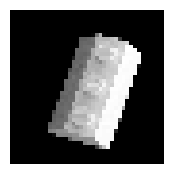

In [7]:
import matplotlib.pyplot as plt

image_sample = train_data.iloc[8]
print(image_sample)
print(f'Shape: {image_sample["Image"].shape}')

fig = plt.figure(figsize=(2, 2)) # 4x4 inches
plt.imshow(image_sample['Image'], cmap='gray')
plt.axis('off')
plt.show()

## 2.1. SVD da matriz de dados centralizados

Antes de calcular o SVD, iremos calcular a matriz de dados centralizados $X$ para os dados de treinamento. Para isto, precisamos achatar cada imagem em um vetor e juntar todas em uma grande matriz $A$, onde as linhas serão as imagens e as colunas serão características.

In [8]:
images = train_data['Image'].to_numpy()
print(f'All images DF shape: {images.shape}')
print(f'Image shape: {images[0].shape}')

A = np.array([image.flatten() for image in images])
print(f'A matrix shape: {A.shape}')
print(A)

All images DF shape: (32000,)
Image shape: (40, 40)
A matrix shape: (32000, 1600)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Agora vamos tirar a média de cada coluna de $A$, gerando um vetor de médias $\mu$. Finalmente, subtraímos de $A$ as médias de suas colunas que estão em $\mu$ para obter a matriz de dados centralizados $X$:

$$ X = A - \mu $$

In [9]:
mu = np.mean(A, axis=0)
X = A - mu

print(f'A shape: {A.shape}')
print(f'X shape: {X.shape}')
print(f'mu shape: {mu.shape}')

# print(A[11990:12010,710])
# print(X[11990:12010,710])
# print(mu[710])

A shape: (32000, 1600)
X shape: (32000, 1600)
mu shape: (1600,)


Agora, calculamos a SVD de $X$.

In [10]:
U, S, Vt = np.linalg.svd(X, full_matrices=False)

In [11]:
print(f'U shape: {U.shape}')
print(f'S shape: {S.shape}')
print(f'Vt shape: {Vt.shape}')

U shape: (32000, 1600)
S shape: (1600,)
Vt shape: (1600, 1600)


## 2.2. Gráfico valores singulares x variabilidade acumulada

Vamos agora gerar um gráfico de número de valores singulares versus variabilidade acumulada.

In [12]:
variability = np.square(S) / np.sum(np.square(S))
cumulative_variability = np.cumsum(variability)

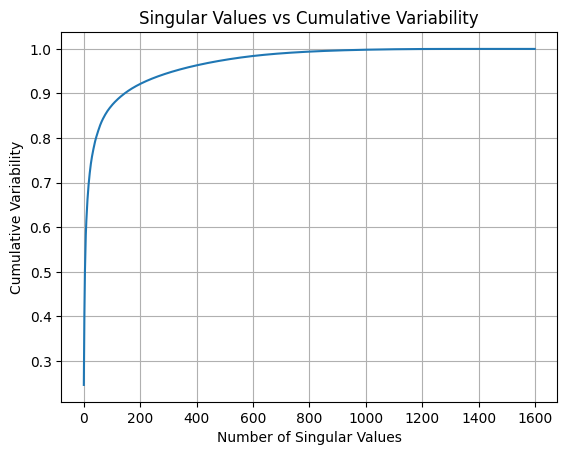

In [13]:
plt.plot(range(len(S)), cumulative_variability)
plt.xlabel('Number of Singular Values')
plt.ylabel('Cumulative Variability')
plt.title('Singular Values vs Cumulative Variability')
plt.grid(True)
plt.show()

Vamos escolher $k = 180$, que representa cerca de $90\%$ da variabilidade acumulada.

Então, vamos tentar visualizar algumas imagens com esse k

In [14]:
def compress_image(image, k):
    U, S, Vt = np.linalg.svd(image)

    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    Vt_k = Vt[:k, :]

    compressed_image = U_k @ S_k @ Vt_k

    return compressed_image

In [15]:
def plot_compressed(img_num: int, ks: list[int]):
    for k in ks:
        image_sample = train_data.iloc[img_num]
        compressed_image = compress_image(image_sample['Image'], k)

        # Plot the original and compressed images side-by-side
        fig, axs = plt.subplots(1, 2, figsize=(4, 2))

        # Original Image
        axs[0].imshow(image_sample['Image'], cmap='gray')
        axs[0].set_title(f'Original {image_sample["Lego Type"]}')
        axs[0].axis('off')

        # Compressed Image
        axs[1].imshow(compressed_image, cmap='gray')
        axs[1].set_title(f'Compressed (k = {k})')
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

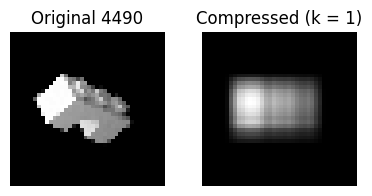

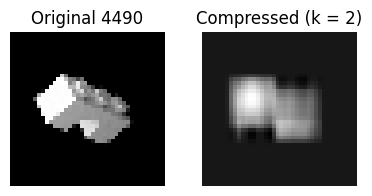

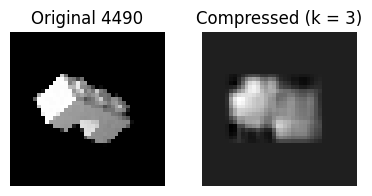

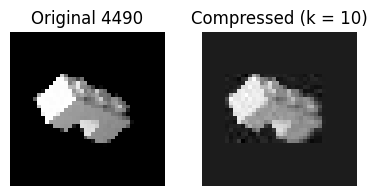

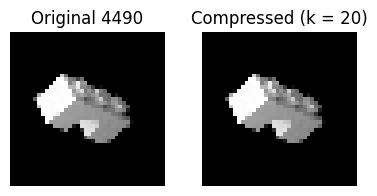

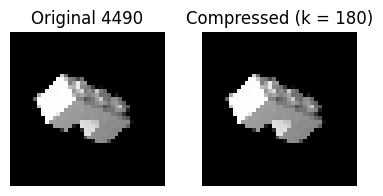

In [16]:
ks = [1, 2, 3, 10, 20, 180]

plot_compressed(12, ks)

### Classificação com dimensionalidade reduzida

De acordo com o gráfico de número de valores singulares versus variabilidade acumulada, escolhemos o $\sigma = 180$, então vamos agora comprimir todas as imagens usando apenas os 180 primeiros valores singulares, e então resolver o problema de classificação utilizando as imagens com dimensão reduzida.

In [17]:
k = 180

In [18]:
from tqdm import tqdm

train_data['Compressed'] = ''
test_data['Compressed'] = ''

for idx, row in tqdm(train_data.iterrows(), total=train_data.shape[0], desc='Compressing Train Images'):
    compressed = compress_image(row['Image'], k)
    train_data.at[idx, 'Compressed'] = compressed

for idx, row in tqdm(test_data.iterrows(), total=test_data.shape[0], desc='Compressing Test Images'):
    compressed = compress_image(row['Image'], k)
    test_data.at[idx, 'Compressed'] = compressed

Compressing Test Images: 100%|██████████| 8000/8000 [00:01<00:00, 4269.76it/s]


### Classificador Naive Bayes

Vamos agora separar os dados em arrays numpy e criar um classificador de Naive Bayes Gaussiano para treiná-lo com os dados de treinamento

In [19]:
train_features = np.stack(train_data['Compressed'].values).reshape(-1, 1600)
train_labels = train_data['Lego Type'].values

test_features = np.stack(test_data['Compressed'].values).reshape(-1, 1600)
test_labels = test_data['Lego Type'].values

In [20]:
print(train_features.shape)
print(train_labels.shape)

(32000, 1600)
(32000,)


In [21]:
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(train_features, train_labels)

GaussianNB()

In [22]:
predicted_labels = classifier.predict(test_features)
accuracy = np.mean(predicted_labels == test_labels)
print("Accuracy:", accuracy)

Accuracy: 0.235375


### Classificador KNN

Devido à baixa acurácia do classificador NB, vamos testar um classificador KNN usando $K = 3$

In [23]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(train_features, train_labels)

KNeighborsClassifier(n_neighbors=3)

In [24]:
predicted_labels = classifier.predict(test_features)
accuracy = np.mean(predicted_labels == test_labels)
print("Accuracy:", accuracy)

Accuracy: 0.563


## 4. Gráfico de Valores singulares versus acurácia

Para cada valor singular $\sigma \in [1,1600]$ vamos calcular a acurácia do classificador KNN com $k = 3$, salvando os resultados parciais em um arquivo de texto. Ao final do experimento, os resultados serão coletados para plotar o gráfico de valores singulares versus acurácia.

Algumas funções auxiliares abaixo

In [25]:
RESULTS_PATH = 'results.csv'

def get_X(train_df, test_df):
    A_train = np.array([image.flatten() for image in train_df['Image']])
    A_test = np.array([image.flatten() for image in test_df['Image']])
    mu = np.mean(A_train, axis=0)
    X_train = A_train - mu
    X_test = A_test - mu
    return X_train, X_test

def reduce_dimension(X, V, k):
    P = X @ V[:,:k]
    return P

def train_classifier_knn(features, labels):
    classifier = KNeighborsClassifier(n_neighbors=3)
    classifier.fit(features, labels)
    return classifier

def train_classifier_gnb(features, labels):
    classifier = GaussianNB()
    classifier.fit(features, labels)
    return classifier

def classify(features, labels):
    predicted_labels = classifier.predict(features)
    accuracy = np.mean(predicted_labels == labels)
    return accuracy

def save_results(k: int, accuracy: float, classifier_type: str):
    with open(f'{classifier_type}_{RESULTS_PATH}', 'a+') as f:
        f.write(f'{k},{accuracy}\n')

Primeiro, vamos centralizar a matriz de dados de treinamento $A_{mxn}$ subtraindo seu vetor das médias de colunas $\mu$:

$$ X = A - \mu $$

Então, vamos gerar a matriz $\^{P}$ de dados projetados no subespaço gerado pelos $k$ primeiros autovetores de $X$ ($span(X\^{V})$) do $\mathbb{R}_m$, onde $\^{V} = V[:,:k]$ e $V$ é a matriz de autovetores de $X$ ordenados decrescentemente:

$$\^{P} = X\^{V}$$

In [26]:
X_train, X_test = get_X(train_data, test_data)
_, _, Vt = np.linalg.svd(X_train, full_matrices=False)
V = Vt.T

### Resultados KNN

In [27]:
with open(f'knn_{RESULTS_PATH}', 'w') as f:
    f.write('k,accuracy\n')

for k in tqdm(range(1, 1601, 10), desc='KNN'):
    P_train = reduce_dimension(X_train, V, k)
    P_test = reduce_dimension(X_test, V, k)

    classifier = train_classifier_knn(P_train, train_data['Lego Type'].values)
    accuracy = classify(P_test, test_data['Lego Type'].values)

    save_results(k, accuracy, 'knn')

KNN: 100%|██████████| 160/160 [07:39<00:00,  2.87s/it]


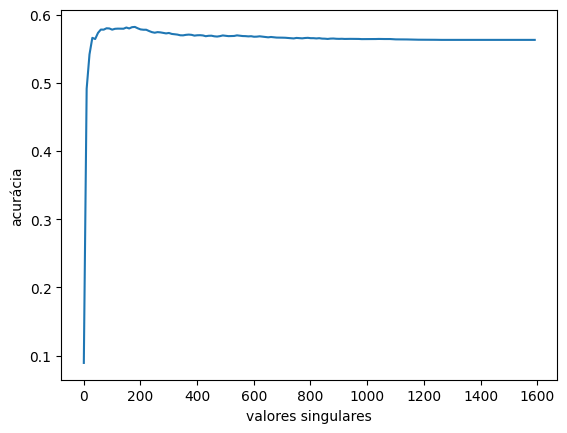

In [28]:
results_df = pd.read_csv(f'knn_{RESULTS_PATH}')
k = results_df['k']
accuracy = results_df['accuracy']
plt.plot(k, accuracy)
plt.xlabel('valores singulares')
plt.ylabel('acurácia')
plt.show()

### Resultados Gaussian Naive Bayes

In [29]:
with open(f'gnb_{RESULTS_PATH}', 'w') as f:
    f.write('k,accuracy\n')

for k in tqdm(range(1, 1601, 10), desc='KNN'):
    P_train = reduce_dimension(X_train, V, k)
    P_test = reduce_dimension(X_test, V, k)

    classifier = train_classifier_gnb(P_train, train_data['Lego Type'].values)
    accuracy = classify(P_test, test_data['Lego Type'].values)

    save_results(k, accuracy, 'gnb')

KNN: 100%|██████████| 160/160 [05:35<00:00,  2.10s/it]


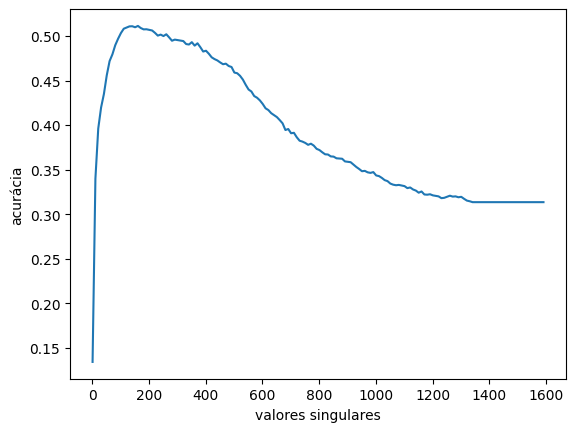

In [30]:
results_df = pd.read_csv(f'gnb_{RESULTS_PATH}')
k = results_df['k']
accuracy = results_df['accuracy']
plt.plot(k, accuracy)
plt.xlabel('valores singulares')
plt.ylabel('acurácia')
plt.show()

## Questões

**1. Considerando uma matriz de dados centralizados $X_{mxn}$, mostrar que
as matrizes $X^TX$ e $XX^T$ possuem os mesmos autovalores não nulos.**

A matriz $X^TX$ é uma matriz de covariância. Portanto, por definição, é sempre simétrica. Como ela é sempre simétrica, pelo **Teorema Espectral** podemos garantir que a matriz é diagonalizável. Isto é: $A = Q\Lambda Q^T$, com $Q$ ortogonal e $\Lambda$ diagonal. 

Seja $x$ um autovetor de $X^TX$ associado ao autovalor $\lambda$,

$$ X^TXx = \lambda x $$
$$ XX^TXx = X \lambda x $$
$$ (XX^T)Xx = \lambda Xx $$

com $Xx = y$

$$ XX^Ty = \lambda y $$

sendo $\lambda$ o autovalor (não nulo, pois caso fosse $y$ seria o vetor nulo então $Xx = 0$ daí $x$ não seria um autovetor) associado ao autovetor $y$ de $XX^T$.

Caso $Xx = 0$, então $X^T0 = \lambda x$. Mas $x$ é autovetor, então não pode ser o vetor nulo, logo teríamos $\lambda = 0$. Como queremos $y \neq 0$, então $Xx \neq 0$, logo $\lambda \neq 0$. $\Box$

**2. Verificar numericamente a proposição anterior, calculando, para o respectivo banco de dados, os autovalores de $X^TX$ e $XX^T$.**

In [31]:
XTX_U, XTX_S, _ = np.linalg.svd(np.dot(np.transpose(X), X), full_matrices=False)
XXT_U, XXT_S, _ = np.linalg.svd(np.dot(X, np.transpose(X)), full_matrices=False)
XXT_S = XXT_S[:1600]
tolerance = 1e-8
same_eigenvalues = np.allclose(XTX_S, XXT_S, atol=tolerance)
print(same_eigenvalues)

False


init_gesdd failed init


**3. Considerando a SVD $X$ = $U S V^T$, verificar, para o respectivo banco de dados, que as colunas de $V$ são os autovetores de $X^TX$ e que as $n$ colunas de $U$ são os autovetores de $XX^T$ associados aos $n$ maiores autovalores. Atenção para com os sentidos dos vetores.**

**4. Comparar, para o respectivo banco de dados, a matriz $Q$ de autovetores de $XX^T$ e a matriz de vetores singulares esquerdos, isto é, $U$ em $X = USV^T$. Justifique por que as duas matrizes são diferentes, mas as submatrizes $U$[:, 0 : t] e $Q$[:, 0 : t] são iguais ($t$ é o índice do primeiro autovalor nulo).**